/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazara/Data2/UCU/CV_GENAI_2_3/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image class: 3


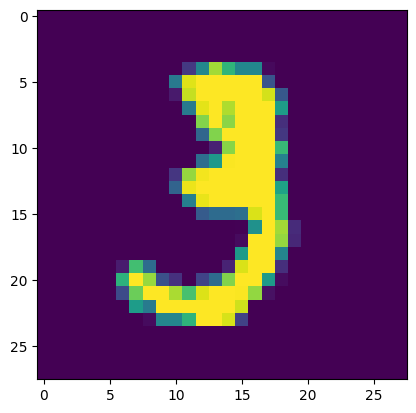

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAEConditioned
from schedulers import DDPM
from schedulers import DDIMSampler, DDPMSampler
from fid import FIDScore


fid_calculator = FIDScore()



mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


mnist_dataset.data[10]

plt.imshow(mnist_dataset.data[10])
print(f"Image class: {mnist_dataset.targets[10]}")

In [2]:
def sample_rect_flow(unet, batch_size, inference_steps=20, device = 'cuda'):
    x0 = torch.randn(batch_size, 1, 28, 28).to(device)
    timesteps = torch.linspace(0, 1, inference_steps).to(device)  # Go from 0 to 1
    xt = x0  # Start from pure noise

    for t in timesteps:
        # t = t.view(1, 1, 1, 1).expand(1, 1, 1, 1)  # Ensure correct shape
        with torch.no_grad():
            predicted_velocity = unet(xt, t.unsqueeze(0))  # Predict the velocity field
        xt = xt + predicted_velocity / inference_steps  # Move along the learned trajectory

    return xt



In [3]:
# Create DataLoader
batch_size = 128
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer and loss function
unet = UNetTimed() #UNetTimedWithVAEConditioned(vae=None,use_condition=False)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
total_params = sum(p.numel() for p in unet.parameters())
print(f"Total parameters: {total_params:,}")

fid_history = []
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        
        # For reflow, we use:
        # x1: the real (clean) image from the dataset
        # x0: a noise sample from a standard Gaussian (e.g., N(0, I))
        x1 = images
        x0 = torch.randn_like(images).to(device)
        
        # timesteps = torch.randint(0, num_steps, (batch_size,), device=device)
        timesteps = torch.rand((batch_size,),device=device)
        
        # The target constant velocity is: v_target = (x1 - x0)
        target_velocity = x1 - x0
        
        # Loop over discrete time steps t in [0, 1]
        # (Here, torch.linspace generates num_steps values between 0 and 1)
        # Add noise to images according to timesteps
        xt = (1 - timesteps.view(-1,1,1,1) ) * x0 + (timesteps.view(-1,1,1,1)) * x1
        
        # Predict noise
        predicted_direction = unet(xt, timesteps)
        
        # Calculate loss
        loss = mse_loss(predicted_direction, target_velocity)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')
    


    with torch.no_grad():
        sample_images = sample_rect_flow(unet.eval(), batch_size, inference_steps=20, device=device).cpu()
        # sample_images = unet.decode_vae(sample_images).cpu()


    # Get a batch of real images for FID calculation
    real_images = next(iter(dataloader))[0]
    real_images = real_images.to(device)

    # Compute FID score
    assert real_images.shape == sample_images.shape, f"Wrong shapes real = {real_images.shape}, sampled = {sample_images.shape}"
    fid_score = fid_calculator.calculate_fid(real_images.cpu(), sample_images.cpu())
    fid_history.append(fid_score)  # Store FID history
    loss_history.append(avg_loss)
    print(f'Epoch {epoch} | FID Score: {fid_score:.4f}')
    # Optional: Save checkpoint
    # if (epoch + 1) % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': unet.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': avg_loss,
    #     }, f'ddpm_checkpoint_epoch_{epoch+1}.pt')

Total parameters: 9,544,437
Epoch 0 | Batch 0 | Loss: 2.4562
Epoch 0 | Batch 100 | Loss: 0.6853
Epoch 0 | Batch 200 | Loss: 0.5108
Epoch 0 | Batch 300 | Loss: 0.4644
Epoch 0 | Batch 400 | Loss: 0.4139
Epoch 0 | Average Loss: 0.6146
Epoch 0 | FID Score: 45.7603
Epoch 1 | Batch 0 | Loss: 0.4584
Epoch 1 | Batch 100 | Loss: 0.3955
Epoch 1 | Batch 200 | Loss: 0.4126
Epoch 1 | Batch 300 | Loss: 0.4006
Epoch 1 | Batch 400 | Loss: 0.4065
Epoch 1 | Average Loss: 0.3940
Epoch 1 | FID Score: 37.5647
Epoch 2 | Batch 0 | Loss: 0.3549
Epoch 2 | Batch 100 | Loss: 0.4146
Epoch 2 | Batch 200 | Loss: 0.3505
Epoch 2 | Batch 300 | Loss: 0.3342
Epoch 2 | Batch 400 | Loss: 0.3411
Epoch 2 | Average Loss: 0.3593
Epoch 2 | FID Score: 36.1305
Epoch 3 | Batch 0 | Loss: 0.3558
Epoch 3 | Batch 100 | Loss: 0.3988
Epoch 3 | Batch 200 | Loss: 0.3322
Epoch 3 | Batch 300 | Loss: 0.3010
Epoch 3 | Batch 400 | Loss: 0.3515
Epoch 3 | Average Loss: 0.3386
Epoch 3 | FID Score: 34.6613
Epoch 4 | Batch 0 | Loss: 0.3288
Epoch 4

KeyboardInterrupt: 

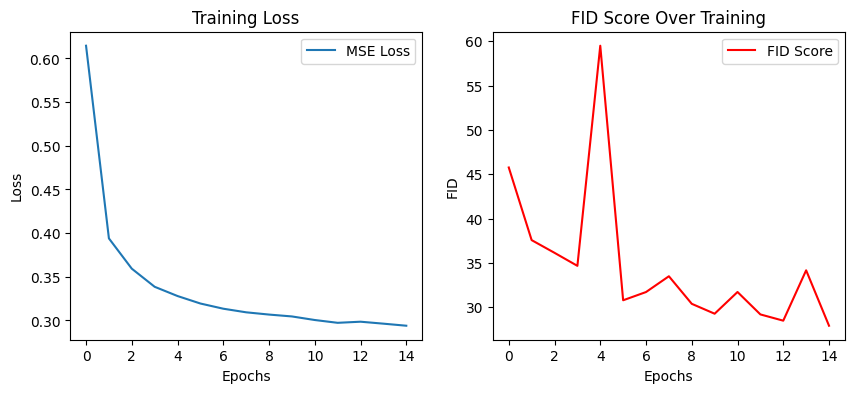

In [4]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_history, label="FID Score", color='r')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("FID Score Over Training")
plt.legend()

plt.show()

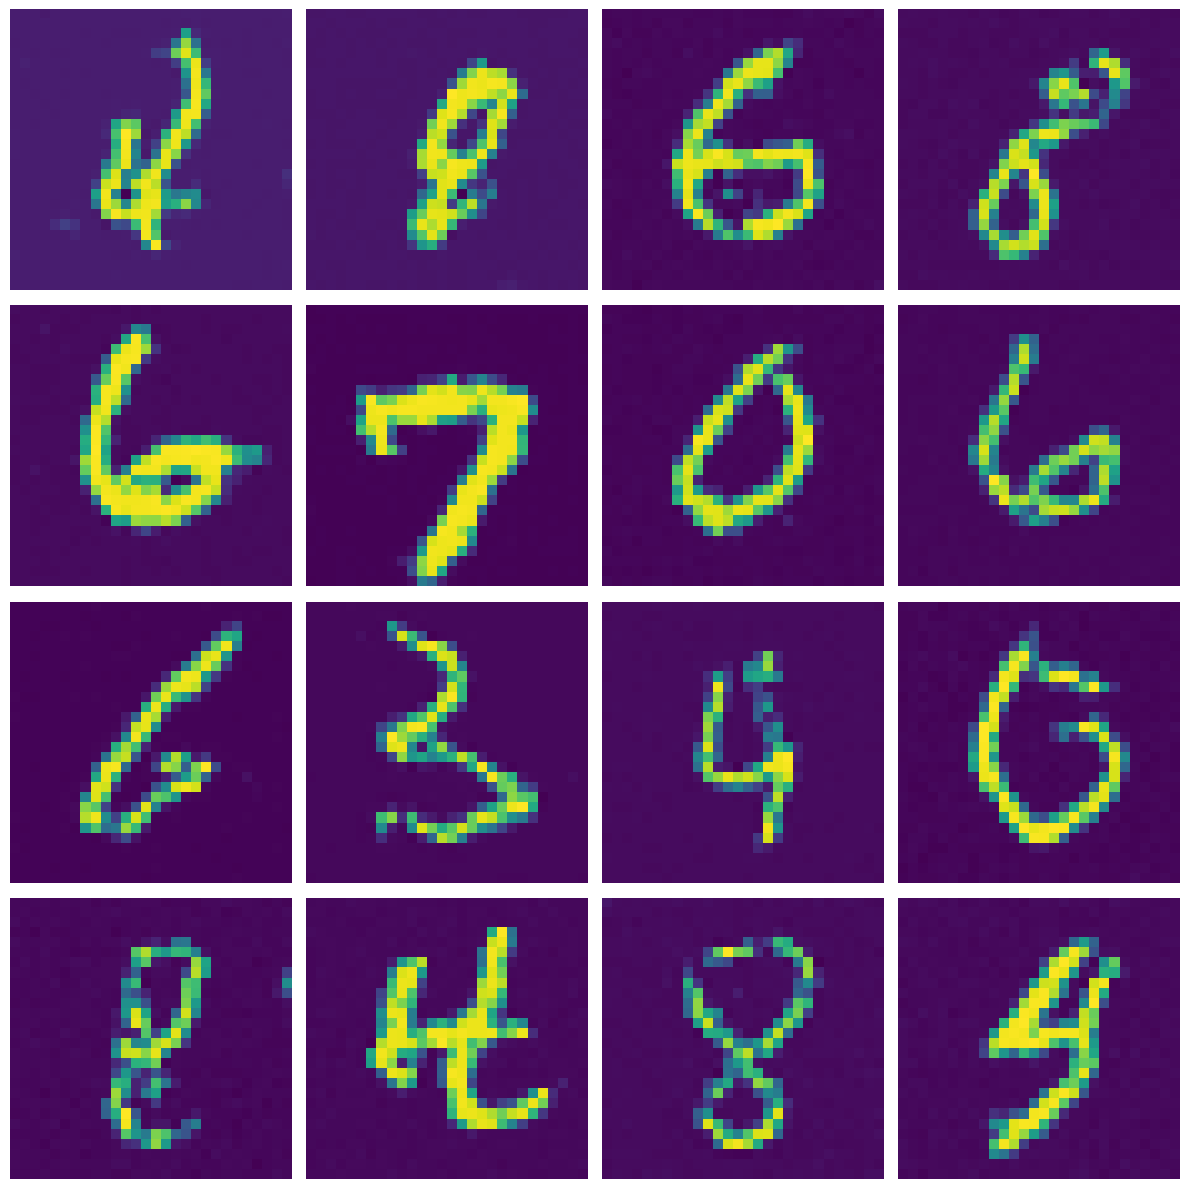

In [13]:
# Set the model to evaluation mode
unet.eval()
# Generate random noise as starting point (x0)
x0 = torch.randn(16, 1, 28, 28).to(device)

# Define number of inference steps (e.g., 10, 20, or 50 instead of 1000)
num_inference_steps = 20  # Much fewer steps than diffusion
timesteps = torch.linspace(0, 1, num_inference_steps).to(device)  # Go from 0 to 1

xt = x0  # Start from pure noise

for t in timesteps:
    # t = t.view(1, 1, 1, 1).expand(1, 1, 1, 1)  # Ensure correct shape
    with torch.no_grad():
        predicted_velocity = unet(xt, t.unsqueeze(0))  # Predict the velocity field
    xt = xt + predicted_velocity / num_inference_steps  # Move along the learned trajectory

# xt should now be close to a denoised image (x1)
denoised_image = xt

# Convert to numpy for visualization
denoised_image = denoised_image.squeeze().cpu().detach().numpy()

# Visualize
# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = denoised_image[i]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()